In [7]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [16]:
random.seed(42)

In [17]:
# import allocations for lead day 5 and lead day 0 and calculate wmape values

allocation_dir = 'allocations'
merged_dir = 'merged'
lead_day = 5
soft_col = f'lead_{lead_day}'
hard_col = 'lead_0'

allocation_0 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_0.csv')
allocation_5 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_5.csv')

merged_5_0 = pd.read_csv(f'{merged_dir}/merged_lead_day_{lead_day}_0.csv')

_, wmape_site = WMAPE.calculate_wmape_site(merged_5_0, soft_col, hard_col)
_, wmape_global = WMAPE.calculate_wmape_global(merged_5_0, soft_col, hard_col)

print(f'wmape_global: {wmape_global}')
print(f'wmape_site: {wmape_site}')

wmape_global: 0.23284907183212267
wmape_site: 0.4854721549636804


In [18]:
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_initial_df, aggregated_target_df, initial_day, target_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')
    return wmape_site

In [19]:
# Generate Neighbor Function
def generate_neighbor(current_allocation, orders_df, eligibility_dict):
    new_allocation = current_allocation.copy()
    max_attempts = 100  # Limit the number of attempts to find a valid swap

    unique_order_ids = orders_df['order_id'].unique()

    for _ in range(max_attempts):
        order_indices = random.sample(range(len(unique_order_ids)), 2)

        order_id1 = unique_order_ids[order_indices[0]]
        order_id2 = unique_order_ids[order_indices[1]]

        items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
        items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()

        site1 = new_allocation[orders_df[orders_df['order_id'] == order_id1].index[0]]
        site2 = new_allocation[orders_df[orders_df['order_id'] == order_id2].index[0]]

        if all(item in eligibility_dict[site2] for item in items1) and all(item in eligibility_dict[site1] for item in items2):
            # Perform the swap if both are eligible
            new_allocation[orders_df[orders_df['order_id'] == order_id1].index] = site2
            new_allocation[orders_df[orders_df['order_id'] == order_id2].index] = site1
            break

    return new_allocation

In [24]:
# k-opt Algorithm
def k_opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, k, max_iter):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    step = 0

    while step < max_iter:
        neighbors = []
        for _ in range(k):
            new_allocation = generate_neighbor(current_allocation, orders_df, eligibility_dict)
            new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)
            neighbors.append((new_allocation, new_energy))

        # Select the best neighbor
        best_neighbor_allocation, best_neighbor_energy = min(neighbors, key=lambda x: x[1])

        if best_neighbor_energy < current_energy:
            current_allocation = best_neighbor_allocation
            current_energy = best_neighbor_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        step += 1

        # Debug statement to trace the progress
        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}')

    # Debug statement for final values
    print(f'Final Step: {step}, Final Best Energy: {best_energy}')
    return best_allocation, best_energy


# Perform k-opt Between Consecutive Days
def perform_k_opt(lead_days, k, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
        
        best_allocation, best_energy = k_opt(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, k, max_iter)
        
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()

In [25]:
# Aggregate, Merge DataFrames and Calculate WMAPE
def calculate_wmape_for_all_days(lead_days, k):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        site_df, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        global_df, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'{k}opt_merged/{k}_merged_allocation_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values

In [26]:

def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()

In [ ]:

lead_days = list(range(18, -1, -1))  # Define the lead days from 18 to 0
k = 2  # Number of neighbors to generate in each iteration
max_iter = 1000

eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')
# Perform k-opt for consecutive lead days
perform_k_opt(lead_days, k, max_iter, eligibility_dict)

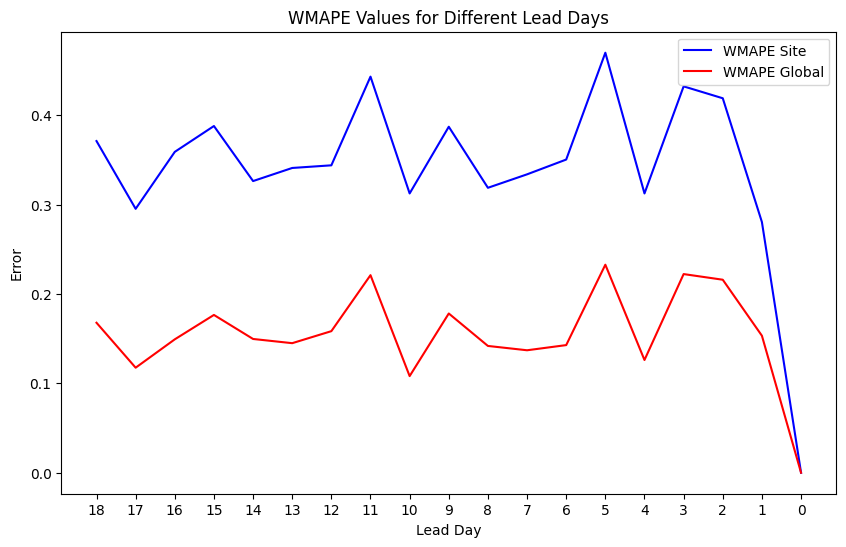

In [28]:
# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days, k)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)